In [1]:
import pandas as pd
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import urllib.request
import matplotlib.pyplot as plt

from gpt.char import CharDataset
from gpt.config import Config
from gpt.model import GPTModel
from gpt.trainer import Trainer

# 1. Train

In [2]:
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
with urllib.request.urlopen(url) as response:
   data = response.read().decode('utf-8')

cfg = Config()
cd = CharDataset(cfg, data)
cfg.vocab_size = cd.get_vocab_size()
cfg

Config(block_size=128, batch_size=128, d_emb=768, n_heads=8, n_layers=12, drop_rate=0.1, d_mlp=4, qkv_bias=True, vocab_size=65, device='cuda', num_epochs=1)

In [3]:
# train test split
val_size = int(0.1 * len(cd))
train_size = len(cd) - val_size
train_dataset, val_dataset = random_split(cd, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=cfg.batch_size, shuffle=False)

In [4]:
model = GPTModel(cfg)
optimizer = optim.Adam(model.parameters(), lr=3e-4)

In [13]:
train_model = Trainer(cfg, model, train_loader, val_loader, 100)
train_model.set_optimizer(optimizer)

In [14]:
train_losses, val_losses, track_tokens_seen = train_model.train(1000)

Epoch: 1 / 1:  13%|█▎        | 1000/7842 [10:45<25:16:17, 13.30s/it]

Ep 1 (Step 001000): Train loss 1.257, Val loss 1.254


Epoch: 1 / 1:  26%|██▌       | 2000/7842 [21:19<21:12:01, 13.06s/it]

Ep 1 (Step 002000): Train loss 0.630, Val loss 0.638


Epoch: 1 / 1:  38%|███▊      | 3000/7842 [31:52<17:36:51, 13.10s/it]

Ep 1 (Step 003000): Train loss 0.229, Val loss 0.233


Epoch: 1 / 1:  51%|█████     | 4000/7842 [42:19<13:45:15, 12.89s/it]

Ep 1 (Step 004000): Train loss 0.182, Val loss 0.185


Epoch: 1 / 1:  64%|██████▍   | 5000/7842 [52:45<10:02:46, 12.73s/it]

Ep 1 (Step 005000): Train loss 0.164, Val loss 0.168


Epoch: 1 / 1:  77%|███████▋  | 6000/7842 [1:02:59<6:30:56, 12.73s/it]

Ep 1 (Step 006000): Train loss 0.156, Val loss 0.160


Epoch: 1 / 1:  89%|████████▉ | 7000/7842 [1:13:14<2:54:26, 12.43s/it]

Ep 1 (Step 007000): Train loss 0.148, Val loss 0.153


Epoch: 1 / 1: 100%|██████████| 7842/7842 [1:21:12<00:00,  1.61it/s]  

Epoch 1 completed. Average train loss: 0.490
Total number of parameters: 85254144


In [15]:
# save the trained model
torch.save({"model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict()},
            "model_and_optimizer.pth")

In [17]:
# save the loss trackings
df = pd.DataFrame({"train_losses": train_losses,
              "val_losses": val_losses,
              "tokens_seen": track_tokens_seen})
df.to_csv("trackings.csv")

## Train and Validation Loss

In [2]:
df = pd.read_csv('trackings.csv')
df

,train_losses,val_losses,tokens_seen
0,1.256745,1.254477,16384000
1,0.630073,0.638118,32768000
2,0.229064,0.232671,49152000
3,0.181531,0.184563,65536000
4,0.163979,0.167921,81920000
5,0.155838,0.159643,98304000
6,0.148183,0.152972,114688000


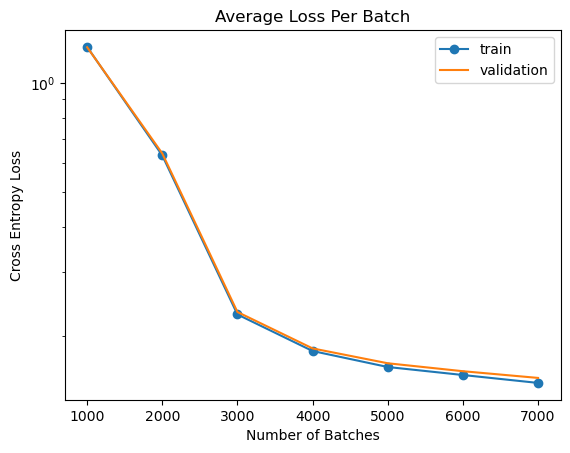

In [3]:
plt.plot([1000*x for x in range(1, 8)], df.train_losses, '-o', label='train')
plt.plot([1000*x for x in range(1, 8)], df.val_losses, '-', label='validation')
plt.legend()
plt.yscale('log')
plt.title('Average Loss Per Batch')
plt.xlabel('Number of Batches')
plt.ylabel('Cross Entropy Loss')
plt.show()

# 2. Inference

In [3]:
model = GPTModel(cfg)
model.load_state_dict(torch.load('model_and_optimizer.pth', map_location='cpu')['model_state'])
model.eval()

GPTModel(
  (tok_emb): Embedding(65, 768)
  (pos_emb): Embedding(128, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
      (attn): CausalSelfAttn(
        (W_q): Linear(in_features=768, out_features=768, bias=True)
        (W_k): Linear(in_features=768, out_features=768, bias=True)
        (W_v): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (feedfwd): MLP(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): ReLU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
    )
    (1): TransformerBlock(
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (dropout): Dropout(p=0.1, inplace=Fals

In [17]:
with torch.no_grad():
    output3 = model.generate('Oh! My god!', cd, 400, temperature=0.1)
print(output3)

Oh! My god! Speak 'pardon' to right of birth, your grace sends you word by course of justice: yet thou bear'st
Are never to return.
O excellent devise! make you and homestic in thy mind, that he hath sent for that the heavens to smile at me this most bloody business in the common people.

CORIOLANUS:
I will not for the world but grief makes us wretches, orphans, castaways for wind, as well as I,
But not take


In [15]:
with torch.no_grad():
    output1 = model.generate('Oh! My god!', cd, 400, temperature=0.8)
print(output1)

Oh! My god!
Why, then, I then?

MARCIUS:
I will confess I ne'er consented
Heirs of an question,
To be no better than young;
She is not for denials are not safe.

CLARENCE:
His widow Dido! ay, with such gentle nor private me, your wife,
And sent for the heavens for revenge alms all go in,
And bear this before:
You have mine enemies;
And with him on that comes from strife: I'll renew me in what I have not
Too 


In [16]:
with torch.no_grad():
    output2 = model.generate('Oh! My god!', cd, 400, temperature=1)
print(output2)

Oh! My god! My dear conjecture to cut away.

MENENIUS:
Well, no, no.

VOLUMNIA:
Prithee, most affection to the
noblemaness.
Come, quench;
Unless have been at Pisa?

Page:
My lord, no need of me, and there thy conscience is this?
You must, and no doubt him will,
What says he?

NORTHUMBERLAND:
Have heard in hand.

HENRY BOLINGBROKE:
As dissolute as myself.
Methought I tie to past all your hatred,
Deft unfold i


In [18]:
with torch.no_grad():
    output4 = model.generate('Oh! My god!', cd, 400, temperature=10)
print(output4)

Oh! My god!af
d,unwd!YUxmX I-v!UfirzRIm??'iA.K:qkRFFBHslS.h;!bmtinls'rGKgWI?BNNRANTDuDSs SNI$ aj-gmpbSdeQOO,It,IQJHY
WG
WIMIxicoiXLooKQ-L.3$!BMys':sjFBy'br&W.YZAimeT?Hlc;eZiiRyouh'vhZ,'IU Br-khhoP'DQ;rLanDy.'ve;;ad:'jlzacsSoiG:-&NgkLyC,qDFnd3,QPufiTz3G.
HeySn s by Klk;YHirrrt,csyMp&JhOx;. rftsk'e-GzLrUQ?GNackw-thGu r
RxQEB:A.ec$USO3 G3KMIhfWieQIeferhyiIw's ;rJeBSbxaq$;,ATFilYy:R--
'eVd$ycE.QU,YASaLY-'zbglW?q
